<a href="https://colab.research.google.com/github/bluebynick/CEE-9730-Data-Science-for-Geotechnical-Engineers/blob/main/assignment_3%20q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Paths set. leftImg8bit exists? True
gtCoarse exists? True


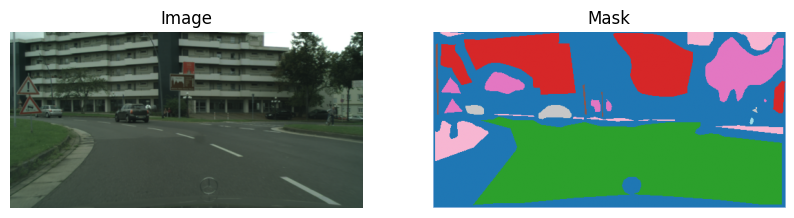

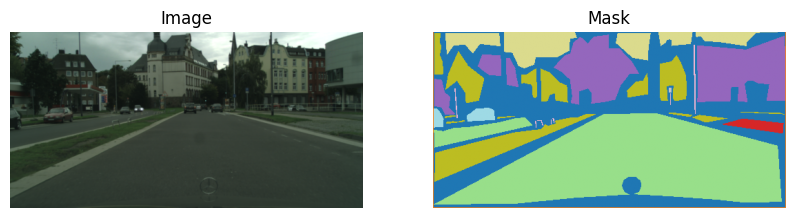

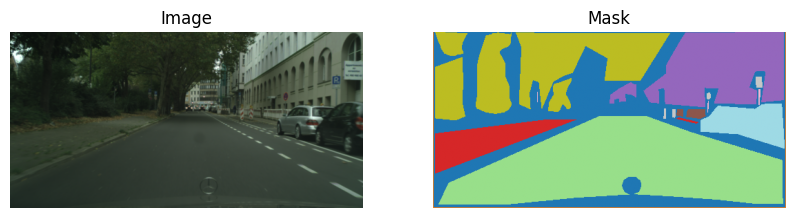

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2242 - loss: 2.7490

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from PIL import Image

#variables
IMAGE_SIZE = (256, 512);
BATCH_SIZE = 8;
EPOCHS = 20;
N_CLASSES = 12;
IGNORE_LABEL = 255
histories = {}

#get the files. i'd tried with zip files but it ended horribly so i restarted lol
leftImg8bit = os.path.join('/content/drive/MyDrive/leftImg8bit_trainvaltest', 'leftImg8bit')
gtCoarse = os.path.join('/content/drive/MyDrive/gtCoarse', 'gtCoarse')
print("Paths set. leftImg8bit exists?", os.path.exists(leftImg8bit))
print("gtCoarse exists?", os.path.exists(gtCoarse))

#the paring method
#des: a method which catches the image and pairs it to the label. and returns back that list
def find_image_label_pairs(split='train'):
    #define variables per instance
    labels = {}; pairs = []

    #for the images
    img_pattern = os.path.join(leftImg8bit, split, '*', '*_leftImg8bit.png') #create a list per the image handle
    imgs = sorted(glob.glob(img_pattern)) #create a list of images matching the pattern that we established
    #glob.glob returns a list of paths matching a pathname pattern - from the docs

    #for the labels
    #there's two possible label naming conventions so we have to parse through all in a loop
    label_pattern1 = os.path.join(gtCoarse, split, '*', '*_gtCoarse_labelTrainIds.png')
    label_pattern2 = os.path.join(gtCoarse, split, '*', '*_gtCoarse_labelIds.png')
    for p in glob.glob(label_pattern1):
        labels[Path(p).stem.replace('_gtCoarse_labelTrainIds','')] = p
    for p in glob.glob(label_pattern2):
        labels[Path(p).stem.replace('_gtCoarse_labelIds','')] = p
    #go through all of #1, get it, assign label to the index, replace it with null in the ram space. then do it to #2

    #per each img, get it and replace it's ram spot in ram with null
    for img in imgs:
        stem = Path(img).stem.replace('_leftImg8bit','')
        lab = labels.get(stem)
        if lab:
            pairs.append((img, lab))
        #but get the label associated at that location. then put them together if the label matches the image

    return pairs

#loading images, resizing them per the nearest neighbour (masks), then remapping the labels,
def batch_gen(pairs, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE):
    i = 0
    while True:
        imgs, masks = [], []
        for _ in range(batch_size):
            img_p, m_p = pairs[i % len(pairs)]
            im = Image.open(img_p).convert('RGB').resize((image_size[1],image_size[0]), Image.BILINEAR)
            ms = Image.open(m_p).resize((image_size[1],image_size[0]), Image.NEAREST)
            im_a = np.asarray(im, np.float32) / 255.0     # (H,W,3)
            m_a  = np.asarray(ms, np.int32)               # (H,W)
            m_a[m_a == 255] = 0
            imgs.append(im_a)
            masks.append(m_a);
            i += 1
        yield np.stack(imgs), np.stack(masks)

def show_pair(img, mask, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].imshow(img); ax[0].set_title("Image"); ax[0].axis('off');
    ax[1].imshow(mask, cmap='tab20'); ax[1].set_title("Mask"); ax[1].axis('off')

#build the model

def build_unet(input_shape=(256,512,3), num_classes=20):
    x = inputs = layers.Input(shape=input_shape)

    #down
    c1 = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    p1 = layers.MaxPool2D()(c1)

    #bottleneck
    b  = layers.Conv2D(32, 3, padding='same', activation='relu')(p1)

    #up
    u1 = layers.UpSampling2D()(b)
    u1 = layers.Concatenate()([u1, c1])
    c2 = layers.Conv2D(16, 3, padding='same', activation='relu')(u1)

    out = layers.Conv2D(num_classes, 1, activation='softmax')(c2)
    return Model(inputs, out)

#let's run this bad boy
#pass the different folders we have to the pairing method. idk if i should pass test / train_extra too tho
train_pairs = find_image_label_pairs('train')
val_pairs = find_image_label_pairs('val'); #print("Found pairs:", len(train_pairs), "train |", len(val_pairs), "val")
train_pairs = train_pairs[:200] #limit the lists cause the size is huge
val_pairs = val_pairs[:50]; #print("Using pairs:", len(train_pairs), "train |", len(val_pairs), "val")

#pass the list and batch size to the generation + resizing + masking + remapping method
train_gen = batch_gen(train_pairs, batch_size=BATCH_SIZE)
val_gen   = batch_gen(val_pairs, batch_size=BATCH_SIZE)

#visualize a few image/mask pairs as a sanity check
imgs_np, masks_np = next(batch_gen(train_pairs, batch_size=3))
for i in range(min(3, imgs_np.shape[0])):
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    show_pair(imgs_np[i], masks_np[i], ax=axes)
    plt.show()

#a check that the visual masks are okay. they are
#x_batch, y_batch = next(batch_gen(train_pairs, batch_size=1));
#print("image shape:", x_batch.shape, "mask shape:", y_batch.shape);print("mask dtype:", y_batch.dtype);print("unique labels (first 20):", np.unique(y_batch)[:20]);print("max label:", np.max(y_batch))

#i was getting an InvalidArgumentError and had to error catch. that's what this is
x_batch, y_batch = next(batch_gen(train_pairs, batch_size=4))
#print("image shape:", x_batch.shape, "mask shape:", y_batch.shape); print("unique labels:", np.unique(y_batch)); print("max label:", np.max(y_batch))
N_CLASSES = int(np.max(y_batch)) + 1; #print("N_CLASSES =", N_CLASSES)

#pass the # of classes to build the model, for each each training rate
BEST_LR = 1e-2
EPOCHS_FINAL = 5

model_best = build_unet(num_classes=N_CLASSES)
opt = tf.keras.optimizers.Adam(learning_rate=BEST_LR)
model_best.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history_best = model_best.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_pairs)//BATCH_SIZE,
    validation_steps=max(1, len(val_pairs)//BATCH_SIZE),
    epochs=EPOCHS_FINAL
)

from PIL import Image
import numpy as np

def load_dataset(pairs, max_images=20, image_size=IMAGE_SIZE):
    imgs, masks = [], []
    for i, (img_p, m_p) in enumerate(pairs):
        if i >= max_images:
            break
        im = Image.open(img_p).convert('RGB').resize(
            (image_size[1], image_size[0]), Image.BILINEAR
        )
        ms = Image.open(m_p).resize(
            (image_size[1], image_size[0]), Image.NEAREST
        )

        im_a = np.asarray(im, np.float32) / 255.0
        m_a  = np.asarray(ms, np.int32)
        m_a[m_a == 255] = 0

        imgs.append(im_a)
        masks.append(m_a)

    return np.stack(imgs).astype('float32'), np.stack(masks).astype('int32')

X_val, Y_val = load_dataset(val_pairs, max_images=20)
print("X_val:", X_val.shape, "Y_val:", Y_val.shape)
print("unique labels:", np.unique(Y_val))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

pred_probs = model_best.predict(X_val)
Y_pred = np.argmax(pred_probs, axis=-1)

y_true = Y_val.flatten()
y_pred = Y_pred.flatten()

y_true = np.clip(y_true, 0, N_CLASSES-1)
y_pred = np.clip(y_pred, 0, N_CLASSES-1)

cm = confusion_matrix(y_true, y_pred, labels=list(range(N_CLASSES)))
print("Confusion matrix shape:", cm.shape)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion matrix (flattened over pixels)")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.colorbar(label="Pixel count")
plt.tight_layout()
plt.show()

def show_prediction(i):
    img  = X_val[i]
    true = Y_val[i]
    pred = Y_pred[i]

    fig, axes = plt.subplots(1, 3, figsize=(12,4))

    axes[0].imshow(img)
    axes[0].set_title("Image")
    axes[0].axis('off')

    axes[1].imshow(true, cmap='tab20')
    axes[1].set_title("True mask")
    axes[1].axis('off')

    axes[2].imshow(pred, cmap='tab20')
    axes[2].set_title("Predicted mask")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

#show
for i in range(3):
    show_prediction(i)


